<h1 style="display: flex; align-items: center; font-size: 35px">
    <img src="../assets/icons/icons8-kawaii-dinosaur-48.png" style="width: 50px; height: 50px; margin-right: 10px;">
    <strong>MRI Brain Alzheimer Classification - DINOv2 Model with Adversarial Attacks</strong>
</h1>

****

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-git-48.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Clone Repository from GitHub
</h1>


In [1]:
# Clone repository from GitHub
# !git clone https://github.com/nivbartov/MRI_Brain_Alzheimer_Classification

# %cd MRI_Brain_Alzheimer_Classification
%cd ..

c:\Dor\TECHNION\deep_learning\Project\MRI_Brain_Alzheimer_Classification


<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-import-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Import Packages
</h1>

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import sys
import os
import numpy as np
import pandas as pd
import torch
from torchsummary import summary
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset, ConcatDataset
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from kornia import augmentation as K
from kornia.augmentation import AugmentationSequential
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import random
import time
from datetime import datetime
import json
import gc
import subprocess

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-function-80.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Import Internal Functions
</h1>


In [3]:
from models import def_models
from utils import utils_funcs
from utils import optuna_search

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-gpu-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Define Definition
</h1>

In [4]:
print(f'torch.cuda.is_available(): {torch.cuda.is_available()}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')
torch.cuda.empty_cache()
gc.collect()
utils_funcs.open_nvitop()

torch.cuda.is_available(): True
device: cuda:0


<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-load-50.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Load Dataset
</h1>

In [5]:
train_set = torch.load('dataset/dataset_variables/train_set.pt')
validation_set = torch.load('dataset/dataset_variables/validation_set.pt')
test_set = torch.load('dataset/dataset_variables/test_set.pt')

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-data-recovery-40.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Model Definition and Initialization
</h1>

In [6]:
# Initialize input and output sizes
input_width = 224
input_height = 224
input_channels = 3
output_channels = 4

dino_v2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

# Freeze DINOv2 layers
for param in dino_v2_model.parameters():
    param.requires_grad = False

# Create DINOv2 model with FC layers before the output
model = def_models.DINOv2(DINOv2_backbone=dino_v2_model, output_channels=output_channels).to(device)

Using cache found in C:\Users\97252/.cache\torch\hub\facebookresearch_dinov2_main


<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-statistics-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Model statistics
</h1>

In [7]:
model_name = type(model).__name__ + '_atk'
print("Model", model_name, "statistics:")
summary(model, (input_channels, input_height, input_width))

Model DINOv2_atk statistics:
Layer (type:depth-idx)                        Output Shape              Param #
├─DinoVisionTransformer: 1-1                  [-1, 384]                 --
|    └─PatchEmbed: 2-1                        [-1, 256, 384]            --
|    |    └─Conv2d: 3-1                       [-1, 384, 16, 16]         (226,176)
|    |    └─Identity: 3-2                     [-1, 256, 384]            --
|    └─ModuleList: 2                          []                        --
|    |    └─NestedTensorBlock: 3-3            [-1, 257, 384]            (1,775,232)
|    |    └─NestedTensorBlock: 3-4            [-1, 257, 384]            (1,775,232)
|    |    └─NestedTensorBlock: 3-5            [-1, 257, 384]            (1,775,232)
|    |    └─NestedTensorBlock: 3-6            [-1, 257, 384]            (1,775,232)
|    |    └─NestedTensorBlock: 3-7            [-1, 257, 384]            (1,775,232)
|    |    └─NestedTensorBlock: 3-8            [-1, 257, 384]            (1,775,232)
|    

Layer (type:depth-idx)                        Output Shape              Param #
├─DinoVisionTransformer: 1-1                  [-1, 384]                 --
|    └─PatchEmbed: 2-1                        [-1, 256, 384]            --
|    |    └─Conv2d: 3-1                       [-1, 384, 16, 16]         (226,176)
|    |    └─Identity: 3-2                     [-1, 256, 384]            --
|    └─ModuleList: 2                          []                        --
|    |    └─NestedTensorBlock: 3-3            [-1, 257, 384]            (1,775,232)
|    |    └─NestedTensorBlock: 3-4            [-1, 257, 384]            (1,775,232)
|    |    └─NestedTensorBlock: 3-5            [-1, 257, 384]            (1,775,232)
|    |    └─NestedTensorBlock: 3-6            [-1, 257, 384]            (1,775,232)
|    |    └─NestedTensorBlock: 3-7            [-1, 257, 384]            (1,775,232)
|    |    └─NestedTensorBlock: 3-8            [-1, 257, 384]            (1,775,232)
|    |    └─NestedTensorBlock: 3-9

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-tuna-50.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Set Hyper-Parameters Using Optuna
</h1>

In [8]:
load_existing_hyperparams = True

if load_existing_hyperparams:
    # Load hyper-parameters (relevant if optuna has already used)
    optuna_params_path = f'./checkpoints/optuna_params/DINOv2/DINOv2_0.9073.json'
    with open(optuna_params_path, 'r') as file:
        hyperparams = json.load(file)
else:
    # Find optimal hyper-parameters using optuna
    hyperparams = optuna_search.optuna_param_search(model_name="DINOv2", loss_criterion=nn.CrossEntropyLoss(), num_epochs_for_experiments=10, device=device, transfer_learning=True)

print(hyperparams)

{'lr': 6.917436540093293e-05, 'optimizer': 'Adam', 'batch_size': 64, 'scheduler': 'CosineAnnealingLR'}


In [9]:
# Set hyper-parameters
batch_size = hyperparams['batch_size']
learning_rate = hyperparams['lr']
optimizer_name = hyperparams['optimizer']
optimizer = getattr(torch.optim, optimizer_name)(model.fc.parameters(), lr=learning_rate)
num_epochs = 20
scheduler = hyperparams['scheduler']
scheduler = StepLR(optimizer, 10, 0.1, verbose=True) if scheduler == "StepLR" else CosineAnnealingLR(optimizer, num_epochs, verbose=True)
criterion = nn.CrossEntropyLoss()

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-loader-80.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Create Data Loaders
</h1>

In [10]:
# Test loader witch batch size of 1 (in order to perform attacks one by one)
testloader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True, num_workers=6, pin_memory=True)

**Load Trained Model**

In [11]:
pretrained_model_path = f"./checkpoints/DINOv2_074712_09102024/DINOv2_140224_09102024_train_0.0121_val_0.0937.pth"
checkpoint = torch.load(pretrained_model_path,weights_only=True)
model.load_state_dict(checkpoint['net'])

<All keys matched successfully>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-knife-64.png" style="width: 50px; height: 50px; margin-right: 5px;">
    Perform Fast Gradient Sign (FGSM) Attack
</h1>

In [12]:
accuracies = []
examples = []
epsilons = [0, .0005, .005, .05, .1, .15, .2, .25, .3]

for eps in epsilons:
    print(f"Performing attack using epsilon {eps}")
    acc, ex = utils_funcs.test_single_point_attack(model, device, testloader, 'fgsm', eps)
    accuracies.append(acc)
    examples.append(ex)

utils_funcs.print_accuracy_table(epsilons, accuracies, parameter_type ='Epsilon')

Performing attack using epsilon 0
Performing attack using epsilon 0.0005
Performing attack using epsilon 0.005
Performing attack using epsilon 0.05
Performing attack using epsilon 0.1
Performing attack using epsilon 0.15
Performing attack using epsilon 0.2
Performing attack using epsilon 0.25
Performing attack using epsilon 0.3
+---------+----------+
| Epsilon | Accuracy |
+---------+----------+
|    0    | 96.0125% |
|  0.0005 | 39.4058% |
|  0.005  | 3.4402%  |
|   0.05  | 8.6005%  |
|   0.1   | 19.3901% |
|   0.15  | 25.7232% |
|   0.2   | 26.5833% |
|   0.25  | 25.9578% |
|   0.3   | 24.5504% |
+---------+----------+


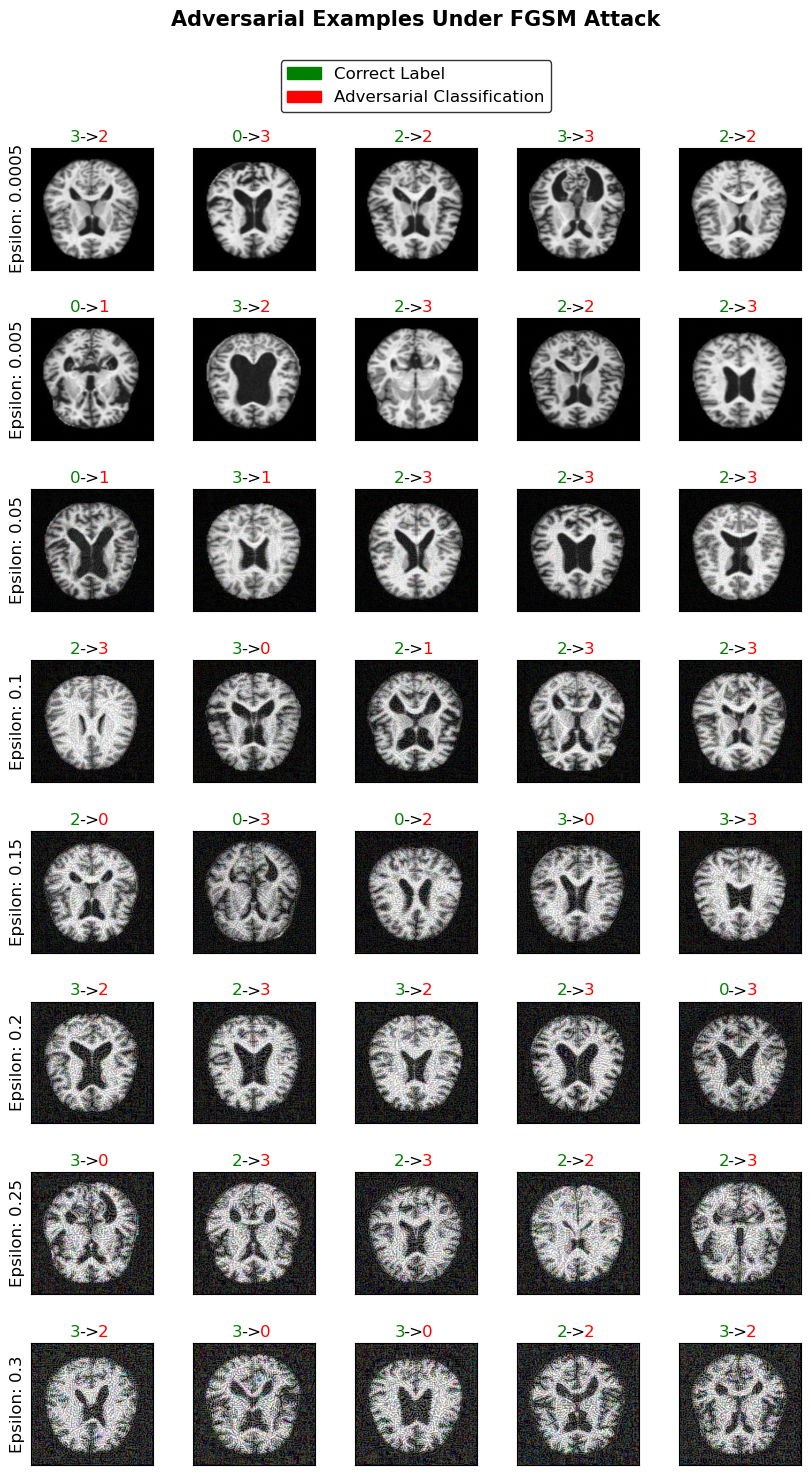

In [13]:
utils_funcs.plot_adversarial_examples(epsilons, examples, attack_name='FGSM', parameter_type='Epsilon')

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-weapon-48.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Perform Projected Gradient Descent (PGD) Attack
</h1>

In [14]:
accuracies = []
examples = []
epsilon = 0.005
alphas = [0, 0.005, 0.01, 0.015, 0.02, 0.0499]
num_iter = 5

for alpha in alphas:
    print(f"Performing attack using alpha {alpha}")
    acc, ex = utils_funcs.test_single_point_attack(model, device, testloader, 'pgd', epsilon, alpha=alpha, num_iter=num_iter)
    accuracies.append(acc)
    examples.append(ex)
    torch.cuda.empty_cache()
    gc.collect()

utils_funcs.print_accuracy_table(alphas, accuracies, parameter_type ='Alpha')

Performing attack using alpha 0
Performing attack using alpha 0.005
Performing attack using alpha 0.01
Performing attack using alpha 0.015
Performing attack using alpha 0.02
Performing attack using alpha 0.0499
+--------+----------+
| Alpha  | Accuracy |
+--------+----------+
|   0    | 96.0907% |
| 0.005  | 0.0000%  |
|  0.01  | 1.4855%  |
| 0.015  | 1.0164%  |
|  0.02  | 1.3292%  |
| 0.0499 | 1.1728%  |
+--------+----------+


<Figure size 2300x1400 with 0 Axes>

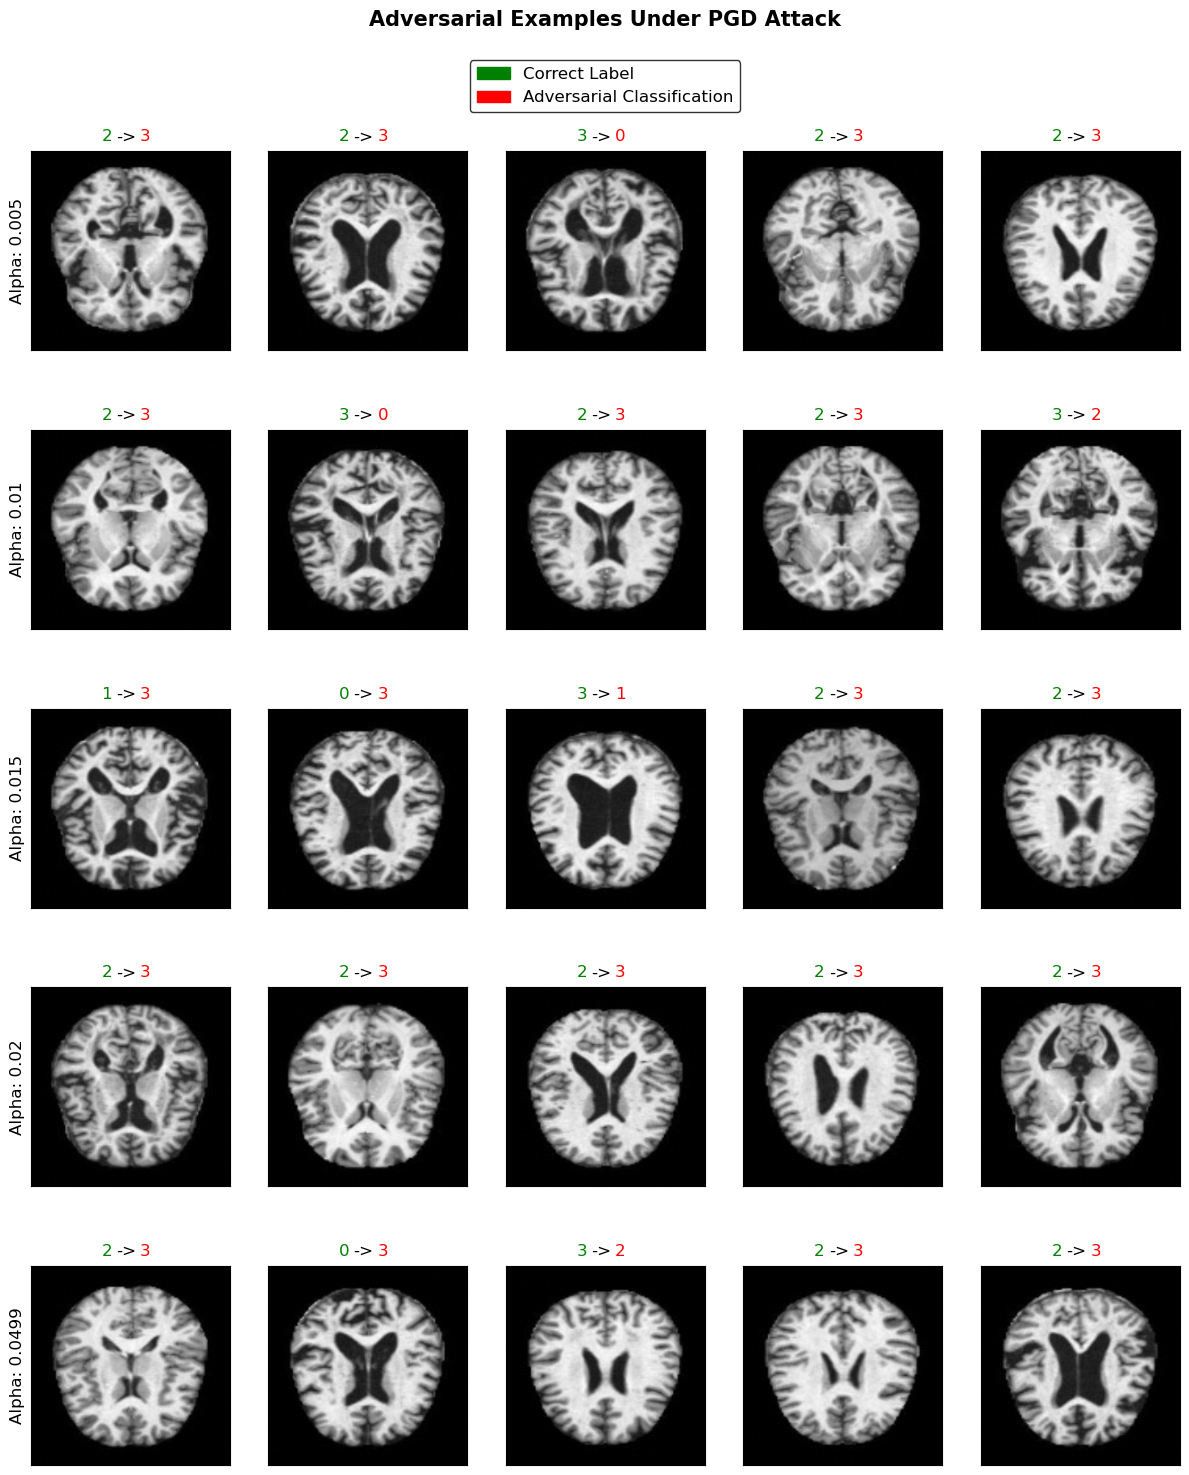

In [16]:
utils_funcs.plot_adversarial_examples(alphas, examples, attack_name='PGD', parameter_type = 'Alpha')

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-augmentation-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Data Augmentations
</h1>

In [11]:
augmentations = K.AugmentationSequential(
    K.RandomHorizontalFlip(p=0.1),
    K.RandomVerticalFlip(p=0.1),
    K.RandomRotation(degrees=10, p=0.1),
    K.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), p=0.1),
    K.RandomBrightness(brightness=(0.8, 1.2), p=0.1),
    K.RandomContrast(contrast=(0.8, 1.2), p=0.1),
    K.RandomGamma(gamma=(0.9, 1.1), p=0.1),
    K.RandomSharpness(p=0.1),
    same_on_batch=False
)

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-training-100.png" style="width: 50px; height: 50px; margin-right: 5px;">
    Adversarial Training
</h1>

In [12]:
# Set hyper-parameters
num_epochs = 20
train_epsilon = epsilon = 0.005
alpha = 0.01
adv_weight = 0.5
num_iter = 5

# Data loading and shuffling
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [15]:
load_existing_params = True
train_loaded_model = False

if load_existing_params:
    model_path = './checkpoints/DINOv2_atk_225702_10102024/DINOv2_atk_120234_12102024_train_0.2628_val_0.5694.pth'
    checkpoint = torch.load(model_path, weights_only=True)
    model.load_state_dict(checkpoint['net'])
    if (train_loaded_model):
        epoch_train_losses, epoch_validation_losses, epoch_train_accuracies, epoch_validation_accuracies =  utils_funcs.adversarial_train_model(model, num_epochs, trainloader, validationloader, device, criterion, optimizer,'pgd', epsilon = epsilon, adv_weight = adv_weight,
                                                                                                                                           alpha = alpha,num_iter=num_iter, kornia_aug=augmentations, use_amp=True, scheduler=scheduler)
    else:
        # Load the saved values from the checkpoint
        epoch_train_losses = checkpoint['train_epoch_losses']
        epoch_validation_losses = checkpoint['validation_epoch_losses']
        epoch_train_accuracies = checkpoint['train_epoch_accuracies']
        epoch_validation_accuracies = checkpoint['validation_epoch_accuracies']
        num_epochs = checkpoint['epoch']
else:
    epoch_train_losses, epoch_validation_losses, epoch_train_accuracies, epoch_validation_accuracies = utils_funcs.adversarial_train_model(model, num_epochs, trainloader, validationloader, device, criterion, optimizer,'pgd', epsilon = epsilon, adv_weight = adv_weight,
                                                                                                                                           alpha = alpha,num_iter=num_iter, kornia_aug=augmentations, use_amp=True, scheduler=scheduler)

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-results-58.png" style="width: 50px; height: 50px; margin-right: 5px;">
    Results
</h1>

In [16]:
test_accuracy = utils_funcs.calculate_accuracy(model, testloader, device)
print("Test accuracy on regular test set: {:.3f}%".format(test_accuracy))

test_accuracy_adversial_attk = utils_funcs.calculate_accuracy_attack(model, testloader,device,attack_type='fgsm',epsilon=train_epsilon)
print("Test accuracy on adversial attacks using FGSM method: {:.3f}%".format(test_accuracy_adversial_attk))

test_accuracy_adversial_attk = utils_funcs.calculate_accuracy_attack(model, testloader,device,attack_type='pgd',epsilon=train_epsilon, alpha=alpha, num_iter=num_iter)
print("Test accuracy on adversial attacks using PGD method: {:.3f}%".format(test_accuracy_adversial_attk))

Test accuracy on regular test set: 92.025%
Test accuracy on adversial attacks using FGSM method: 41.673%
Test accuracy on adversial attacks using PGD method: 71.931%


<Figure size 800x600 with 0 Axes>

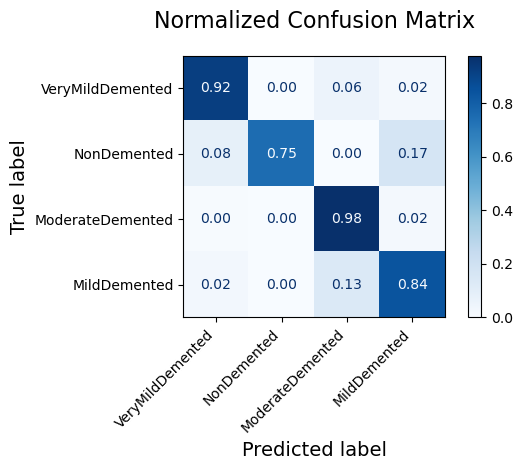

In [17]:
class_names = ['VeryMildDemented', 'NonDemented', 'ModerateDemented', 'MildDemented']
utils_funcs.plot_normalized_confusion_matrix(testloader, model, class_names, device, model_name)

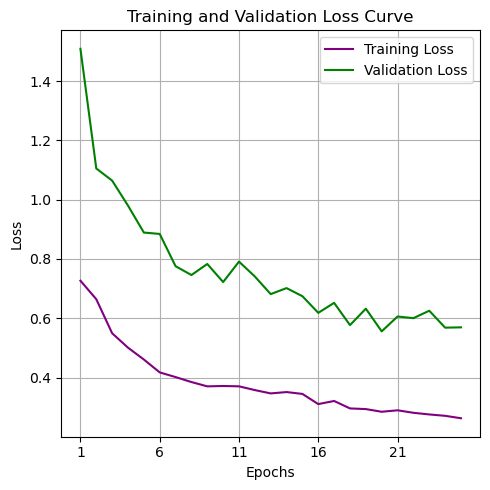

In [18]:
utils_funcs.plot_loss_curve(epoch_train_losses, epoch_validation_losses, num_epochs, model_name)

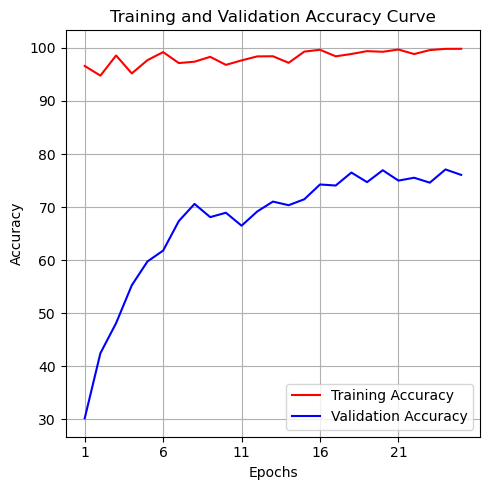

In [19]:
utils_funcs.plot_accuracy_curve(epoch_train_accuracies, epoch_validation_accuracies, num_epochs, model_name)